In [15]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import sys
# Add project root to PYTHONPATH
project_root = os.getcwd()
if str(project_root) not in sys.path and project_root.split('/')[-1] == 'chest_ct_retrieval':
    sys.path.append(str(project_root))
elif str(project_root) not in sys.path and project_root.split('/')[-1] == 'notebooks':
    sys.path.append(str(os.path.normpath('/'.join(project_root.split('/')[:-1]))))

%pwd
%cd "E:\\files\\Documents\\Proyecto Proximity\\chest_ct_retrieval"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
E:\files\Documents\Proyecto Proximity\chest_ct_retrieval


In [ ]:
%cd "E:\\files\\Documents\\Proyecto Proximity\\chest_ct_retrieval"
!python main.py --mode microf1 --config config/base_local.yaml

In [21]:
import subprocess

process = subprocess.Popen(
    ['python', '-u', 'main.py', '--mode', 'microf1', '--no-optimized-loaders', '--config', 'config/base_local.yaml'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True,
    bufsize=1
)

# Stream output line by line
for line in process.stdout:
    print(line, end='') 
process.stdout.close()
process.wait()


CUDA Available: True
Device: cuda:0
Training Mode: microf1
Config: config/base_local.yaml
Optimized Loaders: False
=== MICRO-F1 TRAINING MODE ===
Detected standalone Python - enabling multiprocessing

  0%|          | 0/50 [00:00<?, ?it/s]
### EPOCH 1 START ###


  0%|          | 0/431 [00:24<?, ?it/s]

  0%|          | 0/50 [00:24<?, ?it/s]
Traceback (most recent call last):
  File "E:\files\Documents\Proyecto Proximity\chest_ct_retrieval\main.py", line 211, in <module>
    main(
  File "E:\files\Documents\Proyecto Proximity\chest_ct_retrieval\main.py", line 195, in main
    trainer.fit()
  File "E:\files\Documents\Proyecto Proximity\chest_ct_retrieval\training\trainer_local_microf1.py", line 61, in fit
    train_loss, metrics = self.train_epoch()
                          ^^^^^^^^^^^^^^^^^^
  File "E:\files\Documents\Proyecto Proximity\chest_ct_retrieval\training\trainer_local_microf1.py", line 163, in train_epoch
    outputs = self.model(data)
              ^^^^^^^^^^^^^^^^
  File "

1

In [2]:
import torch
from config.config import load_config
from utils.seed import set_seed
from training.setup import setup_training_run
from training.environment import configure_environment
from eval.metric_loader import load_metrics
from training.data_setup_local import load_dataset_microf1, create_loaders_microf1, create_loaders_microf1_optimized
from training.model_setup_local import initialize_model_micro_f1
from training.trainer_local_microf1 import Trainer


cuda_available = torch.cuda.is_available()
cuda_device = torch.cuda.device(0) if cuda_available else 'cpu'

cfg = load_config("config/base_local.yaml")

set_seed(cfg["training"]["seed"])

run_dirs = setup_training_run(cfg["paths"]["dr2156"]["microf1_runs"])

checkpoints_dir = run_dirs["checkpoints"]
tensorboard_dir = run_dirs["logs"]

configure_environment(cfg)

train_set, test_set, neg_compatibles = load_dataset_microf1(
    cfg["paths"]["dr2156"]["preprocessed_300_int8"], 
    cfg["training"]["seed"], 
    float(cfg["dataset"]["train_frac"]),
    augmentations_arg=cfg["training"]["augmentations"]
)

### MODELO MICRO-F1
p_model, p_loss_fn, p_optimizer, p_scheduler = initialize_model_micro_f1(
    embedding_size=int(cfg["model"]["embedding_size"]),
    lr=float(cfg["training"]["optimizer"]["lr"]),
    weight_decay=float(cfg["training"]["optimizer"]["weight_decay"]),
    cuda=cuda_available
)

loaders = create_loaders_microf1_optimized(
    train_set,
    test_set,
    cfg["training"]["batch"]["batch_size"],
    cuda_available,
    device=cuda_device
)

p_metrics = load_metrics(cfg)

## MICRO-F1 TRAINING
trainer = Trainer(
    train_loader=loaders["train"],
    val_loader=loaders["test"],
    model=p_model,
    loss_fn=p_loss_fn,
    optimizer=p_optimizer,
    scheduler=p_scheduler,
    n_epochs=cfg["training"]["n_epochs"],
    cuda=cuda_available,
    log_interval=cfg["logging"]["log_interval"],
    checkpoint_dir=checkpoints_dir,
    tensorboard_logs_dir=tensorboard_dir,
    metrics=p_metrics,
    start_epoch=0,
    accumulation_steps=3
)
trainer.fit()


  0%|          | 0/50 [00:00<?, ?it/s]


### EPOCH 1 START ###


  0%|          | 0/215 [00:25<?, ?it/s]

KeyboardInterrupt: 

In [2]:
import torch
from config.config import load_config
from utils.seed import set_seed
from training.setup import setup_training_run
from training.environment import configure_environment
from eval.metric_loader import load_metrics
from training.data_setup_local import load_dataset_microf1, create_loaders_microf1
from training.model_setup_local import initialize_model_micro_f1
from training.trainer_local_microf1 import Trainer


cuda_available = torch.cuda.is_available()

cfg = load_config("config/base_local.yaml")

set_seed(cfg["training"]["seed"])

run_dirs = setup_training_run(cfg["paths"]["dr2156"]["microf1_runs"])

checkpoints_dir = run_dirs["checkpoints"]
tensorboard_dir = run_dirs["logs"]

configure_environment(cfg)

train_set, test_set, neg_compatibles = load_dataset_microf1(
    cfg["paths"]["dr2156"]["preprocessed_300_int8"], 
    cfg["training"]["seed"], 
    float(cfg["dataset"]["train_frac"]),
    augmentations_arg=cfg["training"]["augmentations"]
)

### MODELO MICRO-F1
p_model, p_loss_fn, p_optimizer, p_scheduler = initialize_model_micro_f1(
    embedding_size=int(cfg["model"]["embedding_size"]),
    lr=float(cfg["training"]["optimizer"]["lr"]),
    weight_decay=float(cfg["training"]["optimizer"]["weight_decay"]),
    cuda=cuda_available
)

loaders = create_loaders_microf1(
    train_set,
    test_set,
    cfg["training"]["batch"]["batch_size"],
    cuda_available
)

p_metrics = load_metrics(cfg)

In [3]:
s_vol, s_label = train_set[4]
s_tensor = torch.tensor(s_vol.copy()).cuda()
output = p_model(s_tensor)

torch.Size([1, 300, 1, 300, 300])


In [4]:
output

tensor([[ 0.0271,  0.0182, -0.0008, -0.0214]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [5]:
s_label

2

torch.Size([300, 300, 300])
tensor([[[-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490],
         [-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490],
         [-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490],
         ...,
         [-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490],
         [-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490],
         [-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490]],

        [[-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490],
         [-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490],
         [-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490],
         ...,
         [-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490],
         [-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490],
         [-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490]],

        [[-0.4490, -0.4490, -0.4490,  ..., -0.4490, -0.4490, -0.4490],
         [-0.4490

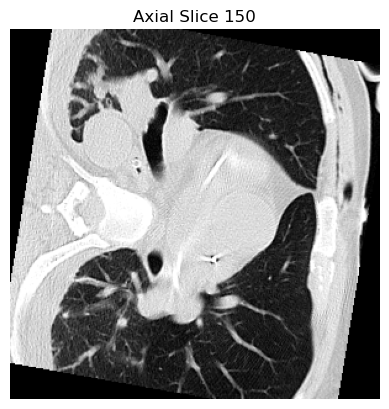

In [5]:
s_vol, s_label = train_set[2]

import matplotlib.pyplot as plt
import torchio as tio
import numpy as np

#print(s_vol)

resize = tio.Compose([
            #tio.Resize([100, 100, -1], image_interpolation='nearest'),
            tio.RescaleIntensity(out_min_max=(0,1))
        ])

tio_image = tio.ScalarImage(tensor=s_vol.copy(), affine=np.eye(4))
#tio_image = resize(tio_image)                

s_vol = tio_image['data'][0]           # remove channel dimension → shape: [D, H, W]

print(s_vol.shape)
print(s_vol)

# Select middle slice in the axial (transverse) plane → [z, y, x]
z_index = s_vol.shape[0] // 2
axial_slice = s_vol[z_index, :, :]

# Plot
plt.imshow(axial_slice.numpy(), cmap='gray')
plt.title(f'Axial Slice {z_index}')
plt.axis('off')
plt.show()


In [13]:
s_vol.shape

(1, 100, 100, 300)

In [ ]:
del tensor, model, subject  # or any other large variables
import gc
gc.collect()
import torch
torch.cuda.empty_cache()